In [3]:
import keras

Using TensorFlow backend.


In [4]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
data = pd.read_csv('Tweets.csv')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569920090440916994,positive,0.6633,NaN,NaN,Delta,NaN,CyntheaH,NaN,0,@JetBlue The chairs could use some TLC. And mo...,NaN,2015-02-23 10:01:52 -0800,"Burlington, Vermont",Eastern Time (US & Canada)
1,570180010125864960,neutral,1.0000,NaN,NaN,American,NaN,CamaroGuySteve,NaN,0,@AmericanAir Embassy Suites\n13341 Woodland Pa...,NaN,2015-02-24 03:14:42 -0800,NaN,NaN
2,568881148325007360,neutral,0.6890,NaN,0.0000,US Airways,NaN,LPNtoMD,NaN,0,"@USAirways Yes, it was Sunday.",NaN,2015-02-20 13:13:29 -0800,NaN,NaN
3,567853644420423680,negative,1.0000,Customer Service Issue,1.0000,United,NaN,_Ana_Paulina,NaN,0,@united is amazing how hard is to talk with cu...,NaN,2015-02-17 17:10:33 -0800,NaN,Guadalajara
4,569628172842479616,negative,0.7025,Can't Tell,0.3702,Delta,NaN,Crimson_Zombie,NaN,0,"@JetBlue sadly, no! I have the app, but it als...",NaN,2015-02-22 14:41:54 -0800,Chicago,NaN


In [7]:
data = data[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,positive,@JetBlue The chairs could use some TLC. And mo...
1,neutral,@AmericanAir Embassy Suites\n13341 Woodland Pa...
2,neutral,"@USAirways Yes, it was Sunday."
3,negative,@united is amazing how hard is to talk with cu...
4,negative,"@JetBlue sadly, no! I have the app, but it als..."


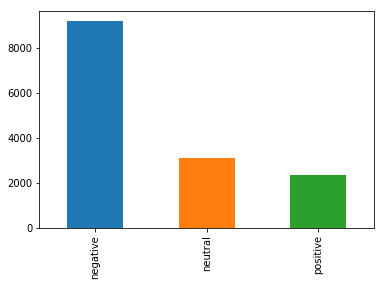

In [8]:
data['airline_sentiment'].value_counts().sort_index().plot.bar()

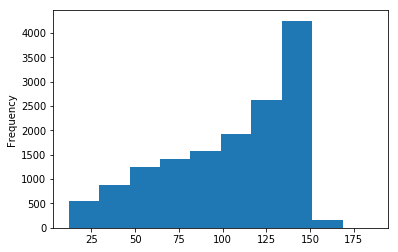

In [9]:
data['text'].str.len().plot.hist()

In [10]:
data['text'] = data['text'].str.replace('@VirginAmerica', '')
data.head()

,airline_sentiment,text
0,positive,@JetBlue The chairs could use some TLC. And mo...
1,neutral,@AmericanAir Embassy Suites\n13341 Woodland Pa...
2,neutral,"@USAirways Yes, it was Sunday."
3,negative,@united is amazing how hard is to talk with cu...
4,negative,"@JetBlue sadly, no! I have the app, but it als..."


In [11]:

data['text'].apply(lambda x: x.lower()) #transform text to lowercase
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'].head()

0    JetBlue The chairs could use some TLC And more...
1    AmericanAir Embassy Suites\n13341 Woodland Par...
2                          USAirways Yes it was Sunday
3    united is amazing how hard is to talk with cus...
4    JetBlue sadly no I have the app but it also is...
Name: text, dtype: object

In [12]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   17,    2, 2459,  161,  249,  199,   10,   98,
        1027, 1600,   15,    2,  884,   76,   32,    4, 1916, 1122,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   13, 4604, 4605, 2723,  674, 4606,   55],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   12,  166,   20,   23,  675],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           5,   14,  348,   63,  564,   14,    1,  383,   25,   50,   42],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   17, 1789,   28,   

In [13]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [15]:

y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)]

positive [0 0 1]
neutral [0 1 0]
neutral [0 1 0]
negative [1 0 0]
negative [1 0 0]


[None, None, None, None, None]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:

batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
 - 75s - loss: 0.6545 - acc: 0.7294
Epoch 2/8
 - 80s - loss: 0.4467 - acc: 0.8305
Epoch 3/8
 - 71s - loss: 0.3542 - acc: 0.8679
Epoch 4/8
 - 67s - loss: 0.2941 - acc: 0.8922
Epoch 5/8
 - 67s - loss: 0.2434 - acc: 0.9086
Epoch 6/8
 - 67s - loss: 0.2086 - acc: 0.9255
Epoch 7/8
 - 67s - loss: 0.1795 - acc: 0.9373
Epoch 8/8
 - 67s - loss: 0.1590 - acc: 0.9413


In [18]:

model.save('sentiment_analysis.h5')

In [19]:
predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

JetBlue The chairs could use some TLC And more power outlets in the area would be a bonus Headed to UniversalORL  [0.95028687 0.04651617 0.00319691] [0 1 0]
AmericanAir Embassy Suites
13341 Woodland Park Drive
Herndon Virginia 20171 
US 
17034640200 [9.9958116e-01 3.3984604e-04 7.8980673e-05] [1 0 0]
USAirways Yes it was Sunday [9.9971038e-01 2.4807241e-04 4.1417617e-05] [1 0 0]
united is amazing how hard is to talk with customer service  [9.9820912e-01 1.4751117e-03 3.1583552e-04] [1 0 0]
JetBlue sadly no I have the app but it also is experiencing difficulties The flight information boards are keeping me updated [0.8684036  0.12854227 0.00305409] [0 1 0]


[None, None, None, None, None]

In [20]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 483
Neutral predictions: 435
Negative predictions: 2010
Real positive: 474
Real neutral: 645
Real negative: 1809
